# Sentiment Analysis of Financial News stories

I will explain the reason for each cell and step beforehand and then provide more detail as comments as we go.

Here is an overview of the process.

### Rough Outline:
	1. Identify relevant news stories related to economic health and collect urls.
	2. Scrape the stories, and identify the content and publish date.
	3. Use a sentiment anlyser to analyse the content.
	4. Average the news stories results for each day
	5. Scrape the earnings call reports for companies in NASDAQ 100
	6. Identify the reports that fall in our lookback window (from the 26th sept) and then summarise the reports.
    7. Perform sentiment analysis.
	8. Averge the report results for each day
	9. Combine the report and news results in a 30:70 weighting.
	10. Then include previous days score in todays as a 20:80 split this ensure continuity
    11. Plot the timeseries and the price of the S&P 500 for the lookback window and assess the predictive powers
        (correlation).

We begin by importing the neccessary packages

In [1]:
!pip install newsapi-python
!pip install newspaper3k
from newsapi import NewsApiClient
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import requests
from transformers import pipeline, AutoTokenizer
import nltk
import json
from collections import defaultdict
from newspaper import Article
from datetime import datetime, timedelta
from googlesearch import search
from bs4 import BeautifulSoup
import yfinance as yf
from datetime import datetime, timedelta

nltk.download('punkt')         # We require this download for the nlp summary of the articles, it returns true if successful

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Step 1.

Use newsapi to search for us sources that write solely on business news. We then produce a search query that captures stories about the health of the economy, good and bad.
The query is structured as:
 '("US" OR "United States") AND ("Earnings Call Report" OR "recession" OR "economic slowdown" OR "market downturn" OR "equity market volatility" OR "economic growth" OR "economic resilience" OR "recovery" OR "expansion" OR "bull market" OR "strong labor market" OR "consumer spending" OR "economic outlook" OR "market trends" OR "macroeconomic forecast")'
This will encapsulate as many of the economic terms that might hint at the health of the economy.

We also think about the lookback window, how far back we want to look for stories. We are limited here to 1 month from the date its run. Since this script may be run all the way up to the 25th of October, we begin getting stories from the 26th of September to ensure it functions as expected when being tested.

When we run the newsapi we collect everything returned from this search, from the identified sources, within the timeframe. We store the urls for later.


In [2]:
# Get the list of matched sources for US business news
def get_matched_sources(client):
    # Find all sources for NewsAPI about business and based in the US
    business_sources = client.get_sources(category='business')
    us_sources = client.get_sources(country='us')

    # We are unable to search for US and business sources, so we will have to identify the sources in both.
    # We could include US general news sources but I imagine we won’t gain any in-depth info from here that
    # we haven’t got from the business sources.
    matched_sources = []
    for us_source in us_sources['sources']:
        for business_source in business_sources['sources']:
            if us_source['id'] == business_source['id']:
                matched_sources.append(us_source['id'])

    # Join the sources together as a string to pass to the web-scraper.
    return ','.join(matched_sources)



# Function to collect news articles over a date range
def collect_articles(client, sources, date_ranges, query):
    info_total = []

    for date_range in date_ranges:
        start_date, end_date = date_range
        stories = client.get_everything(q=query,
                                        language='en',
                                        sources=sources,
                                        from_param=start_date,
                                        to=end_date,
                                        page_size=100)

        # Get URLs and publication dates
        info = [[x['url'], x['publishedAt']] for x in stories['articles']]

        # Extend the list
        info_total.extend(info)

    return info_total

# Inititate the news api
api_key = '54a078f2262342de8c4cfaad2b0dc521'

# Set up client with the key
client = NewsApiClient(api_key=api_key)

# We create a nested list with the weeks that we are interested in
date_list = [
                ['2024-09-26','2024-09-29'],
                ['2024-09-30','2024-10-06'],
                ['2024-10-07','2024-10-13'],
                ['2024-10-14','2024-10-21'],
]

# The query for searching for articles
query = '("US" OR "United States") AND ("Earnings Call Report" OR "recession" OR "economic slowdown" OR "market downturn" OR "equity market volatility" OR "economic growth" OR "economic resilience" OR "recovery" OR "expansion" OR "bull market" OR "strong labor market" OR "consumer spending" OR "economic outlook" OR "market trends" OR "macroeconomic forecast")'

sources = get_matched_sources(client)
# We collate the info for the returned stories.
articles_info = collect_articles(client, sources, date_list, query)

# See how many we have
print(f"Total articles collected: {len(articles_info)}")

Total articles collected: 179


### Step 2.
We use a package called newspaper that has a feature Article that allows us to parse news stories accurately and also has a function that can summarise the story. This is useful as stories can reach many thousands of characters and therfore tokens which are expensive and are limited in amount that can passed to an LLM. By summarising we can get a concise shorter version of the story. There might be some loss of detail but the overall sentiment of the article should be retained.

We run the scrapper and store the title, published date and the summary to a dict store.

In [3]:
# Function to fetch and process articles by date
def process_articles(info_total):
    # Create a defaultdict to group articles by date
    articles_by_date = defaultdict(list)

    # We search for each URL in the list, we use an agent to help access pages
    for url, publish_date in info_total:
        article = Article(url, headers={'User-Agent': 'Mozilla/5.0'})

        # Download and parse the article so we can extract information and use the NLP summarizer
        article.download()
        article.parse()


        # Call the nlp method to generate the summary and keywords
        article.nlp()

        # Create a dictionary to store article details
        article_data = {
            'title': article.title,
            'publish_date': publish_date[:10],  # Store the date in YYYY-MM-DD
            'summary': article.summary,
            'keywords': article.keywords,
            'text' : article.text
        }

        # Group articles by publish date
        articles_by_date[article_data['publish_date']].append(article_data)

    return dict(articles_by_date)  # Convert to a regular dict for JSON serialization

articles_by_date = process_articles(articles_info)

articles_json = json.dumps(articles_by_date, indent=4)

# Print the JSON structure
print(articles_json)

# Collect a list of the dates that are published, incase there were none for a certain day
dates_list = sorted(list(articles_by_date.keys()))

{
    "2024-09-29": [
        {
            "title": "A researcher who studied Trump's plans to control the Fed said it could tank the economy",
            "publish_date": "2024-09-29",
            "summary": "Economists at the Peterson Institute studied what would happen if Trump undermined Fed independence.\nThe study's lead researchers dug into the economic impact of three of Trump's campaign promises: mass deportations, tariffs, and eroding Fed independence.\nThough Trump promises an America First economic agenda, McKibbin said that taking control of the Fed would get him the opposite results.\nAdvertisementHe doesn't think the public is paying enough attention to the risks of Trump's Fed proposals or the overall murkiness of the candidates' economic policy.\n\"If you're going to advocate a policy, there has to be evidence as to why you're advocating that policy,\" McKibbin said.",
            "keywords": [
                "researcher",
                "economy",
                "

### Step 3.
We will then pass the title and summary into a sentiment analyser, specifically finbert from HuggingFace. This analyses the content and returns a positive, negative or neutral sentiment, along with a confidence score from 0 to 1. We store these results in the dict.

In [4]:
# Load the sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")

# Function to analyze the sentiment of articles
def analyze_sentiment(articles_by_date, dates_list, sentiment_analyzer):
    no = 0
    # Loop through the dates in the list and then through the articles on that date and store the result in the article dict
    for date in dates_list:
        for article in articles_by_date[date]:
            no += 1
            title = article['title']
            summary = article['summary']
            keywords = article['keywords']

            # The prompt isn't ideal as the model might not be able to be instructed in the same way as, say, ChatGPT.
            # The instructions themselves may be analyzed as a part of the content. Therefore, the prompt is short and sweet,
            # as to not influence too much.
            prompt = (f'The article is titled "{title}" and reads: {summary}'
)

            # Perform sentiment analysis
            result = sentiment_analyzer(prompt)

            # Store the sentiment analysis result in the article dictionary
            article['result'] = result

            # Print the progress
            print(f"Processed article {no}")

    return articles_by_date

analyzed_articles = analyze_sentiment(articles_by_date, dates_list, sentiment_analyzer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Processed article 1
Processed article 2
Processed article 3
Processed article 4
Processed article 5
Processed article 6
Processed article 7
Processed article 8
Processed article 9
Processed article 10
Processed article 11
Processed article 12
Processed article 13
Processed article 14
Processed article 15
Processed article 16
Processed article 17
Processed article 18
Processed article 19
Processed article 20
Processed article 21
Processed article 22
Processed article 23
Processed article 24
Processed article 25
Processed article 26
Processed article 27
Processed article 28
Processed article 29
Processed article 30
Processed article 31
Processed article 32
Processed article 33
Processed article 34
Processed article 35
Processed article 36
Processed article 37
Processed article 38
Processed article 39
Processed article 40
Processed article 41
Processed article 42
Processed article 43
Processed article 44
Processed article 45
Processed article 46
Processed article 47
Processed article 48
P

### Step 4.
We then want to calculate a single data point for each day. To do that we need to understand the task.

The task asks for a positive sentiment score to indicate fear of recession and negative is we are recession safe. To satisfy this we must calculate an average of the scores of each story for each day.

We use the confidence level as a strength metric and we subtract this from the day total if it’s labelled positive (as it indicates a positive outlook on economic health, ie lack of recession) and added if its labelled negative (to satisfy the tasks positive score for negative outlook).

We then divide the score by the number of stories, including neutral, as we want to dilute extreme sentiment with neutral. This means if we have lots of neutral stories and one highly negative, the score will reflect this.

We store these results in a list with the days that are represented.

In [5]:
# Function to calculate the sentiment score and count positive, negative, and neutral results
def calculate_sentiment(articles_by_date, dates_list):
    # Set up variables: results list, positive, negative, and neutral counters
    res_list = []
    pos = 0
    neg = 0
    neu = 0

    # Loop through the dates and articles to access results
    for date in dates_list:
        # Overall sentiment result is initiated
        res = 0
        # Number of articles for the date
        no_articles = len(articles_by_date[date])

        for article in articles_by_date[date]:
            # Conditions to determine if we are adding or subtracting the score, based on the label
            if article['result'][0]['label'] == 'Negative':
                neg += 1
                res += article['result'][0]['score']
            elif article['result'][0]['label'] == 'Positive':
                pos += 1
                res -= article['result'][0]['score']
            # Counting the number of neutral results
            elif article['result'][0]['label'] == 'Neutral':
                neu += 1

        # Average for the day by dividing the sum score by the number of articles
        res_list.append(res / no_articles)
        print(f"{date}: {no_articles} articles processed")

    return res_list, pos, neg, neu

dates_list = sorted(list(articles_by_date.keys()))

res_list, pos, neg, neu = calculate_sentiment(articles_by_date, dates_list)

# Creating the result dict
result_dict_1 = dict(zip(dates_list, res_list))

2024-09-26: 2 articles processed
2024-09-27: 5 articles processed
2024-09-28: 1 articles processed
2024-09-29: 4 articles processed
2024-09-30: 9 articles processed
2024-10-01: 8 articles processed
2024-10-02: 5 articles processed
2024-10-03: 7 articles processed
2024-10-04: 11 articles processed
2024-10-05: 8 articles processed
2024-10-06: 7 articles processed
2024-10-07: 6 articles processed
2024-10-08: 4 articles processed
2024-10-09: 6 articles processed
2024-10-10: 13 articles processed
2024-10-11: 7 articles processed
2024-10-12: 6 articles processed
2024-10-13: 5 articles processed
2024-10-14: 6 articles processed
2024-10-15: 10 articles processed
2024-10-16: 12 articles processed
2024-10-17: 10 articles processed
2024-10-18: 8 articles processed
2024-10-19: 4 articles processed
2024-10-20: 5 articles processed
2024-10-21: 10 articles processed


### Step 5.

We then are interested in using Earnings call Reports to provide specific indicators of economic health. We need a repeatable and reusable method of accessing appropriate information, ie transcripts or analysis. We opt to search for the reports for the top 100 companies in the US (non-finaical), the NASDAQ 100. We opt for this as it gives a broad view of the economy. The S&P 500 is another that could be used but, it is much larger. NDX is a good middle ground.

We search for the latest earnings reports on Yahoo Finance and find that, whilst its not perfect it does return a large number of useable articles. We could maunally find the latest but opt instead to use this method. We dont search for any site as we may be directed to a site that is behind a pay wall or barrier, somewhere like the investor relations page for the companies. I found that Yahoo offered wither analysis or transcripts of the reports and this is sifficient.

In [6]:
# List of NASDAQ 100 companies
companies = [
    "ADBE", "AMD", "ABNB", "GOOGL", "GOOG", "AMZN", "AEP", "AMGN",
    "ADI", "ANSS", "AAPL", "AMAT", "ARM", "ASML", "AZN", "TEAM",
    "ADSK", "ADP", "BKR", "BIIB", "BKNG", "AVGO", "CDNS", "CDW",
    "CHTR", "CTAS", "CSCO", "CCEP", "CTSH", "CMCSA", "CEG", "CPRT",
    "CSGP", "COST", "CRWD", "CSX", "DDOG", "DXCM", "FANG", "DLTR",
    "DASH", "EA", "EXC", "FAST", "FTNT", "GEHC", "GILD", "GFS",
    "HON", "IDXX", "ILMN", "INTC", "INTU", "ISRG", "KDP", "KLAC",
    "KHC", "LRCX", "LIN", "LULU", "MAR", "MRVL", "MELI", "META",
    "MCHP", "MU", "MSFT", "MRNA", "MDLZ", "MDB", "MNST", "NFLX",
    "NVDA", "NXPI", "ORLY", "ODFL", "ON", "PCAR", "PANW", "PAYX",
    "PYPL", "PDD", "PEP", "QCOM", "REGN", "ROP", "ROST", "SBUX",
    "SMCI", "SNPS", "TTWO", "TMUS", "TSLA", "TXN", "TTD", "VRSK",
    "VRTX", "WBD", "WDAY", "XEL", "ZS"
]


# Function to search for earnings call URLs for each company
def search_earnings_calls(companies):

  # Collect the urls for the earnings call of each company
    report_url = []

    for ticker in companies:
        print(f"Searching for: {ticker}")

        # Query to search Yahoo Finance for Q4 or Q3 2024 earnings call#
        query = f'Yahoo Finance AND ({ticker} Q4 2024 earnings call OR {ticker} Q3 2024 earnings call) site:finance.yahoo.com'

        # Perform search and collect the first result (num=1, stop=1)
        for url in search(query, num=1, stop=1):
            report_url.append(url)
            print(url)
    return report_url

report_url = search_earnings_calls(companies)

Searching for: ADBE
https://finance.yahoo.com/news/q3-2024-adobe-inc-earnings-124114012.html
Searching for: AMD
https://finance.yahoo.com/quote/AMD/
Searching for: ABNB
https://finance.yahoo.com/quote/ABNB/
Searching for: GOOGL
https://finance.yahoo.com/quote/GOOG/analysis/
Searching for: GOOG
https://finance.yahoo.com/quote/GOOG/analysis/
Searching for: AMZN
https://finance.yahoo.com/news/amazon-com-inc-nasdaq-amzn-142326608.html
Searching for: AEP
https://finance.yahoo.com/news/q3-2024-adobe-inc-earnings-124114012.html
Searching for: AMGN
https://finance.yahoo.com/quote/AMGN/
Searching for: ADI
https://finance.yahoo.com/news/q3-2024-analog-devices-inc-060543093.html
Searching for: ANSS
https://finance.yahoo.com/news/q3-2024-w-r-berkley-122758735.html
Searching for: AAPL
https://finance.yahoo.com/quote/AAPL/analysis/
Searching for: AMAT
https://finance.yahoo.com/news/q3-2024-applied-materials-inc-125352502.html
Searching for: ARM
https://finance.yahoo.com/news/q3-2024-arm-holdings-plc

### Step 6.
We then need to ensure that the reports/analysis were published within the lookback window. This is where we see a large loss in number. We have searched for Q3 and Q4 but may not be returned the most recent report. Therefore we need to identify the reoports we can use.

We only allow reports that were published after the 26th of Spetember as this was the start of the news stories window. We dont want to include earning reports on their own, only alongisde the news stories. We also dont want to waste time using the nlp summariser if it cant be used.

We then summarise the earnings report transcript/analysis and store in a dict.

In [7]:
# Create reports dict (reports will refer to the earnings reports/analysis)
reports_by_date = defaultdict(list)

# Cutoff date
cutoff_date_l = datetime.strptime("2024-09-25", "%Y-%m-%d")
cutoff_date_u = datetime.strptime("2024-10-21", "%Y-%m-%d")

def fetch_publish_date(url):

  # scrape publish date of page
    response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        date_tag = soup.find('time')
        if date_tag and 'datetime' in date_tag.attrs:
            return date_tag['datetime'][:10]
    return None

def process_article(url, cutoff_date_l, cutoff_date_u):
    article = Article(url, headers={'User-Agent': 'Mozilla/5.0'}, timeout=10)
    try:
        article.download()
        article.parse()
        publish_date = fetch_publish_date(url)

        # Only summarise and store if the date is within the window, this saves time and computation
        if publish_date and (cutoff_date_l < datetime.strptime(publish_date, "%Y-%m-%d") < cutoff_date_u):
            article.nlp()
            return {
                'title': article.title,
                'publish_date': publish_date,
                'summary': article.summary,
                'keywords': article.keywords,
            }
    except Exception as e:
        print(f"An error occurred while processing {url}: {e}")
    return None

def generate_reports(report_url, cutoff_date_l, cutoff_date_u):
    reports_by_date = defaultdict(list)
    # loop through urls and get articles
    for url in report_url:
        report_data = process_article(url, cutoff_date_l, cutoff_date_u)
        if report_data:
            reports_by_date[report_data['publish_date']].append(report_data)
            print(report_data['publish_date'])
    return dict(reports_by_date)

reports_by_date = generate_reports(report_url, cutoff_date_l, cutoff_date_u)
report_json = json.dumps(reports_by_date, indent=4)

# Print the JSON to inspect
print(report_json)

2024-10-13
2024-10-17
2024-10-18
2024-10-20
2024-09-27
2024-10-17
2024-10-16
2024-10-12
2024-10-18
An error occurred while processing https://finance.yahoo.com/calendar/earnings/: Article `download()` failed with HTTPSConnectionPool(host='finance.yahoo.com', port=443): Read timed out. (read timeout=7) on URL https://finance.yahoo.com/calendar/earnings/
An error occurred while processing https://finance.yahoo.com/calendar/earnings?symbol=TSLA: Article `download()` failed with HTTPSConnectionPool(host='finance.yahoo.com', port=443): Read timed out. (read timeout=7) on URL https://finance.yahoo.com/calendar/earnings?symbol=TSLA
2024-10-18
{
    "2024-10-13": [
        {
            "title": "Amazon.com, Inc. (NASDAQ:AMZN) Is A Goldman Sachs Phase 2 AI Stock For The Next AI Wave",
            "publish_date": "2024-10-13",
            "summary": "We recently made a list of Goldman Sachs\u2019 Best Phase 2 AI Stocks: Top 24 High Conviction AI Stocks.\nIn this piece, we will look at where Ama

### Step 7.

We now use the same senitment analyser to anlyse the summary of the earnings call reports. We save the results in the reports dict.

In [8]:
# Get the dates of the reports as a sorted list
report_dates = sorted(list(reports_by_date.keys()))

# View this list
print(report_dates)

reports_analysed = analyze_sentiment(reports_by_date,report_dates, sentiment_analyzer)

['2024-09-27', '2024-10-12', '2024-10-13', '2024-10-16', '2024-10-17', '2024-10-18', '2024-10-20']
Processed article 1
Processed article 2
Processed article 3
Processed article 4
Processed article 5
Processed article 6
Processed article 7
Processed article 8
Processed article 9
Processed article 10


### Step 8.

We now calculate the average of the reports for each day, exactly like we did before.

We save the result in a report result dict.

In [9]:

reports_res_list, pos, neg, neu = calculate_sentiment(reports_by_date, report_dates)

# Creating the result dict
result_dict_2 = dict(zip(report_dates, reports_res_list))

# Print the result dict
print(result_dict_2)

2024-09-27: 1 articles processed
2024-10-12: 1 articles processed
2024-10-13: 1 articles processed
2024-10-16: 1 articles processed
2024-10-17: 2 articles processed
2024-10-18: 3 articles processed
2024-10-20: 1 articles processed
{'2024-09-27': -1.0, '2024-10-12': -1.0, '2024-10-13': 0.0, '2024-10-16': -0.9999901056289673, '2024-10-17': -0.4999987483024597, '2024-10-18': -0.9999988476435343, '2024-10-20': -1.0}


### Step 9.

We now combine the results of both the news stories and reports. We want align the results for each day.

Important to note that we have news stories for all days in the window, but the same isnt true for the reports. We therefore have some days with only the results of the news stories.

We then combine the results of both the news stories and reports in a 70:30 split. We do this as to place hugher importance on the news stories, as they encapsulate a larger sentiment of the economic health and not just 1 company. Individual company health is a good indicator but isnt 'more' important than the overall health which we can get from the news.

In [10]:
combined_results = {}
# loop through the news results
for date, news_res in result_dict_1.items():
    if date in result_dict_2:
        # If date is in both, combine results
        combined_results[date] = (news_res, result_dict_2[date])
    else:
        # If date is only in news results, leave the reports blank
        combined_results[date] = (news_res, None)

# Check for dates in earnings_results not in news_results
for date, earnings_res in result_dict_2.items():
    if date not in combined_results:
        combined_results[date] = (None, earnings_res)

# Delete the date '' that has made its way from the news stories
if '' in combined_results:
    del combined_results['']




for date in combined_results:
    # tuple -> list so it can be modified
    temp = list(combined_results[date])

    if temp[1] is None:
        # If earnings result is None, set the combined result to the news result
        temp.append(temp[0])
    elif temp[0] is None:
        # If news result is None, set combined result to the earnings result
        temp.append(temp[1])
    else:
        # Combine news and earnings results using the 0.7 and 0.3 weights
        combined_value = (0.7 * temp[0]) + (0.3 * temp[1])
        temp.append(combined_value)

    # list back to tuple and update the dict
    combined_results[date] = tuple(temp)



### Step 10

We now need to make the time series continuous but including context of the previous day. I have done this by modifying each days result to be weighted with the previous. This will dampen out large swings in sentiment and allow for a more continuous progression. I have placed high importance on the previous day (30%) but with more time and testing I would find an optimum weighting. The same is true for the news to report weight. However i feel like this is a good starting point.

In [11]:
weighted_res_list = []
dates = list(combined_results.keys())
for i in range(len(combined_results)):
    weighted_res = 0
    if i == 0:
        weighted_res = combined_results[dates[i]][2]
    else:
        weighted_res = (0.7*combined_results[dates[i]][2]) + (0.3 * combined_results[dates[i-1]][2])
    weighted_res_list.append(weighted_res)


### Step 11

Now we want to see how our model did. We assess its ability by plotting it against an index. I wont plot against the ^NDX as we used this to build the model, in a way. Instead we can easily switch for the S&P 500.

What the model should ideally do in theory is for a positive sentiment (fear of recession) we should see a downturn in the price and vice versa.

We plot this to see how we do.

[*********************100%***********************]  1 of 1 completed
<ipython-input-12-46f704c75664>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['Close'].fillna(method='ffill', inplace=True)
<ipython-input-12-46f704c75664>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data['Close'].fillna(method='ffill', inplace=True)


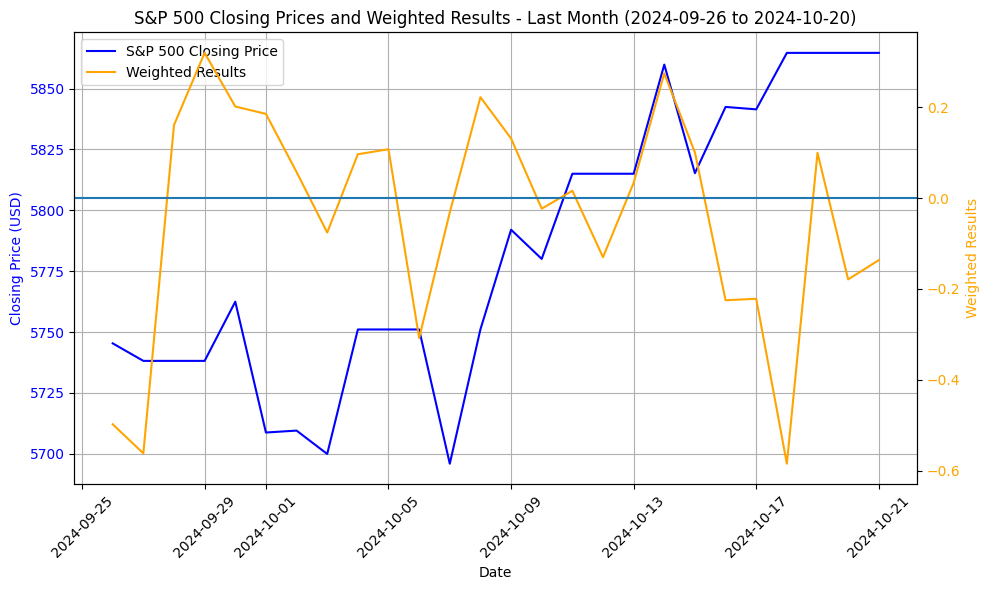

In [12]:
ticker = "^SPX"

# Define the start and end dates
end_date = '2024-10-21'
start_date = '2024-09-26'

# Fetch S&P 500 index data for the last month
data = yf.download(ticker, start=start_date, end=end_date)

# Create a DataFrame with the full date range, including weekends/non-trading days
full_dates = pd.DataFrame(dates_list, columns=['Date'])
full_dates['Date'] = pd.to_datetime(full_dates['Date'])

# Merge the trading data with the full date range
data = data.reset_index()  # Reset index to have 'Date' as a column
merged_data = pd.merge(full_dates, data[['Date', 'Close']], on='Date', how='left')

# Forward-fill to account for non-trading days (weekends, holidays)
merged_data['Close'].fillna(method='ffill', inplace=True)

# Assuming weighted_res_list is defined and matches the length of merged_data['Date']
# Here I'm using random data for demonstration; replace with your actual data

# Create a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot S&P 500 Closing Prices
ax1.plot(merged_data['Date'], merged_data['Close'], label="S&P 500 Closing Price", color='blue')
ax1.set_xlabel("Date")
ax1.set_ylabel("Closing Price (USD)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)
ax1.tick_params(axis='x', labelrotation=45)

# Create a second y-axis for weighted results
ax2 = ax1.twinx()  # Instantiate a second y-axis sharing the same x-axis

# Plot Weighted Results
ax2.plot(merged_data['Date'], (weighted_res_list), label="Weighted Results", color='orange')
ax2.set_ylabel("Weighted Results", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.axhline(y=0)
# Set title and legends
plt.title(f"S&P 500 Closing Prices and Weighted Results - Last Month ({start_date} to {end_date})")

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

fig.tight_layout()  # Adjust layout to make room for the second y-axis
plt.show()

We see no obvious relationship between the too. We can try and look at the return of the S&P between days. Excuse the copied code with a simple .pct_change() added.

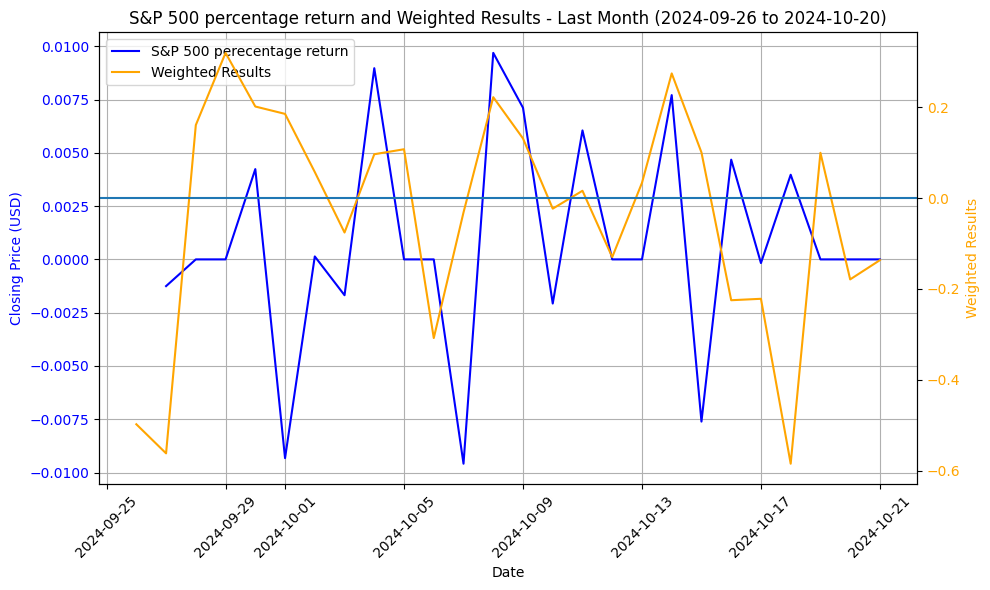

In [13]:
# Create a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot S&P 500 Closing Prices
ax1.plot(merged_data['Date'], merged_data['Close'].pct_change(), label="S&P 500 perecentage return", color='blue')
ax1.set_xlabel("Date")
ax1.set_ylabel("Closing Price (USD)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)
ax1.tick_params(axis='x', labelrotation=45)

# Create a second y-axis for weighted results
ax2 = ax1.twinx()  # Instantiate a second y-axis sharing the same x-axis

# Plot Weighted Results
ax2.plot(merged_data['Date'], (weighted_res_list), label="Weighted Results", color='orange')
ax2.set_ylabel("Weighted Results", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.axhline(y=0)
# Set title and legends
plt.title(f"S&P 500 percentage return and Weighted Results - Last Month ({start_date} to {end_date})")

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

fig.tight_layout()  # Adjust layout to make room for the second y-axis
plt.show()

Again no obvious relationship. We can comfirm this with a correlation test. This will tell us the strength and direction of the relationship if there is any.

In [14]:
correlation = pd.Series(weighted_res_list).corr(merged_data['Close'])
print(correlation)

-0.1774227722074973


This indicates a very weak negative correlation, which is in the right direction of what wed expect but the strength is very weak.


## Improvements

We see this model hasnt performed well in predicting the return of the index. Ideally I would have a longer lookback period but this is limited by the newsapi free tier. I would also like to have access to LLM models that allow for lager token spend, ie I can put the whole news article in and analyse that instead of a summary. I had investigated chunking up the text, summarising each bit and then combining the summaries together before summarising the combined summaries. However this proved computationaly exhausting. The built nlp summarizer of newspaper3k offered a nice alternative to this. Its not perfect but it can provide a good summary.

The sentiment analysis with finbert from HuggingFace similarly was good but not ideal. It didnt allow for much prompt engineering. It simply analysed the whole prompt and so if i had asked it to 'provide sentiment analysis on the fear of recession' it provided very negative results on the account of the phrase 'fear of recession'. Therefore prompt engineering couldnt be fully explored here.

If i had a model that could accept the large text and was quick, we prompt it with 'You are a sentiment analysis machine, tasked with providing a quantitative result regarding the fear of recession. You are too focus on common indicators and phrases that describe economic health. You are too use a scale of -10 to 10 to describe the sentiment, where -10 is recession free and 10 is fear of recession. Analyse the following article titled {title} that says {article}.'

This would be subject to modifications.

However, where Finbert was useful is it has been trained soley on financial data, it produces reliable and repeatable results, that are easy to parse. Therefore it was suitable to use for this task.